# ABS Retail Trade 8501

Note: the ABS usually releases the Retail Trade data in tranches, with the second tranch delivered about a week after the first.

## Python set-up

In [1]:
# system imports
import sys

# analytic imports
import matplotlib.pyplot as plt
import pandas as pd

# local imports
from abs_data_capture import (
    fix_abs_title,
    get_ABS_meta_and_data,
    get_fs_constants,
    get_meta_constants,
    get_plot_constants,
)
from plotting import (
    calc_growth,
    clear_chart_dir,
    plot_covid_recovery,
    plot_growth_finalise,
    recalibrate_series,
    set_chart_dir,
)

# pandas display settings
pd.options.display.max_rows = None
pd.options.display.max_columns = 999

# display charts in the notebook ...
SHOW = True

## Get data from the ABS

### Retail trade data

In [2]:
# get ABS retail data
retail_catalogue_id = "8501"
source, CHART_DIR, META_DATA = get_fs_constants(retail_catalogue_id)
retail_dict = get_ABS_meta_and_data(
    retail_catalogue_id, 
    # verbose=True
)
if retail_dict is None:
    sys.exit(-1)

retail_meta = retail_dict[META_DATA]
RECENT, plot_times, plot_tags = get_plot_constants(retail_meta)
did_col, id_col, table_col, type_col, unit_col = get_meta_constants()

Found URL for a ZIP file on ABS web page
Retrieving zip-file from cache ...
Extracting DataFrames from the zip-file ...


In [3]:
# Check latest monthly date
retail_dict["1"].index[-1]

Period('2023-08', 'M')

In [4]:
# check latest quarterly date
if "7" in retail_dict:
    print(retail_dict["7"].index[-1])

In [5]:
# Monthly tables are numbered 1 through 4
# Quarterly tables are numbered 5 and following. 
retail_meta['Table'].unique()

array(['1', '2', '3', '4'], dtype=object)

### CPI deflator

In [6]:
# get CPI tables from the ABS
cpi_catalogue_id = "6401"
cpi_dict = get_ABS_meta_and_data(cpi_catalogue_id)
if cpi_dict is None:
    sys.exit(-1)
cpi_meta = cpi_dict[META_DATA]

Found URL for a ZIP file on ABS web page
Retrieving zip-file from cache ...
Extracting DataFrames from the zip-file ...


In [7]:
# extract quarterly All Groups CPI index from the ABS data
cpi_index = "Index Numbers ;  All groups CPI ;  Australia ;"
cpi_table = "2"
cpi_row = cpi_meta[
    (cpi_meta[did_col] == cpi_index) & (cpi_meta[table_col] == cpi_table)
].iloc[0]
cpi_id = cpi_row[id_col]
cpi_q = cpi_dict[cpi_table][cpi_id]

# rebase quarterly CPI index to one
cpi_q = cpi_q / cpi_q.iloc[-1]

# calculate recent monthly CPI growth
MONTHS_PER_QTR = 3
QUARTERS = 2
PERIOD = MONTHS_PER_QTR * QUARTERS  # in months
monthly_growth = (cpi_q.iloc[-1] / cpi_q.iloc[-1 - QUARTERS]) ** (1 / PERIOD)

# create a monthly CPI index ...
cpi_m = (
    cpi_q.resample("M", convention="end")
    .sum()
    .interpolate(
        method="index",
        limit_area="inside",
    )
)

# extrapolate monthly index forward ...
ADDITIONAL = 4
for i in range(ADDITIONAL):
    cpi_m[cpi_m.index[-1] + 1] = cpi_m.iloc[-1] * monthly_growth

monthly_growth, cpi_m.tail(12)

(1.0036615279225265,
 Series ID
 2022-11    0.972326
 2022-12    0.978310
 2023-01    0.982797
 2023-02    0.987285
 2023-03    0.991773
 2023-04    0.994515
 2023-05    0.997258
 2023-06    1.000000
 2023-07    1.003662
 2023-08    1.007336
 2023-09    1.011025
 2023-10    1.014727
 Freq: M, Name: A2325846C, dtype: float64)

## Plot - retail turnover by industry

### Plotting initialisation / constants

In [8]:
clear_chart_dir(CHART_DIR)
set_chart_dir(CHART_DIR)
plt.style.use("fivethirtyeight")

LONG_LABEL = 35  # characters

### Main plotting loop

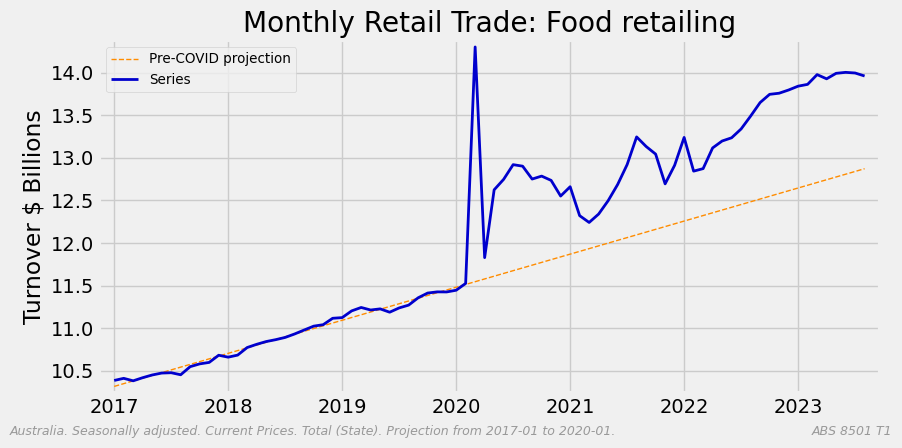

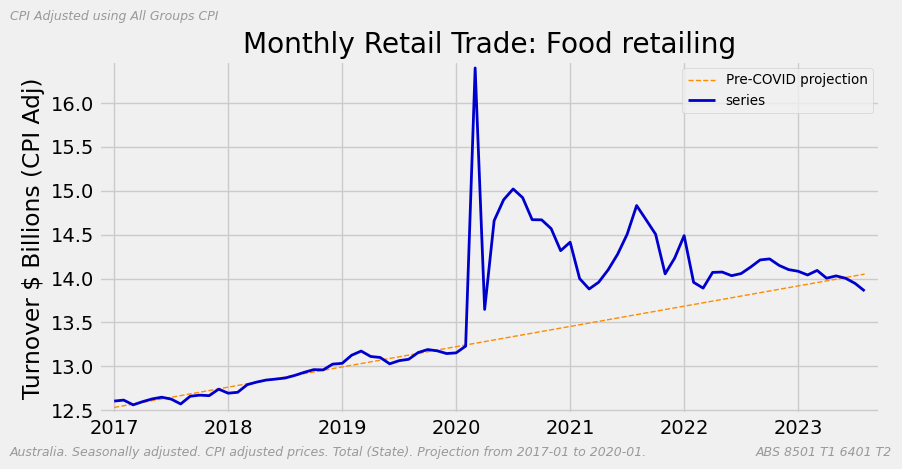

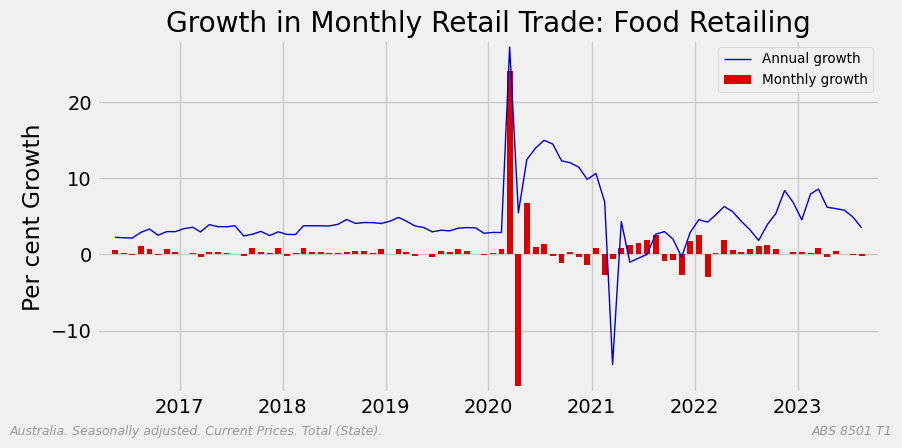

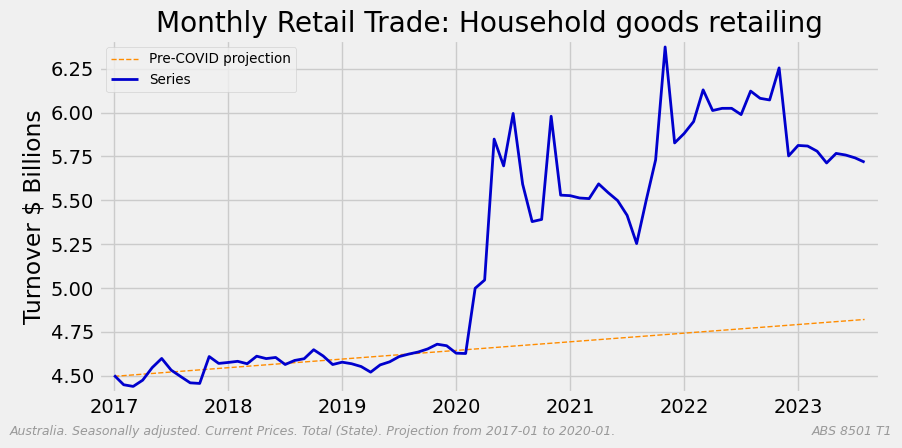

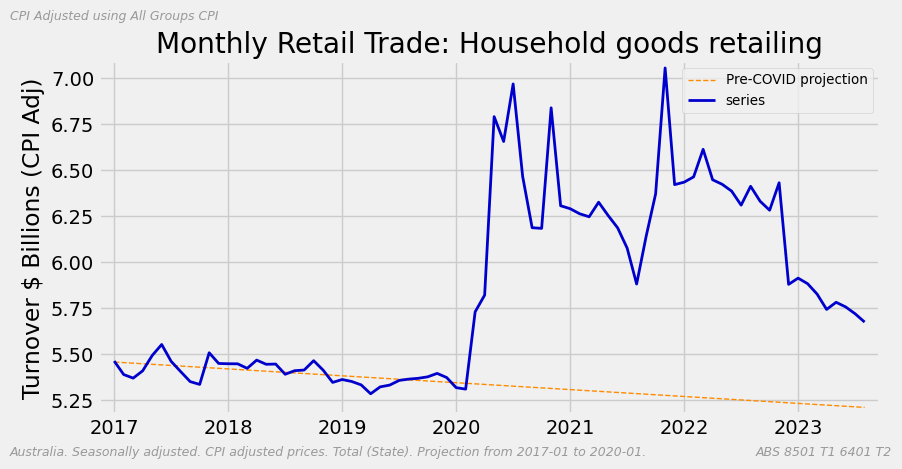

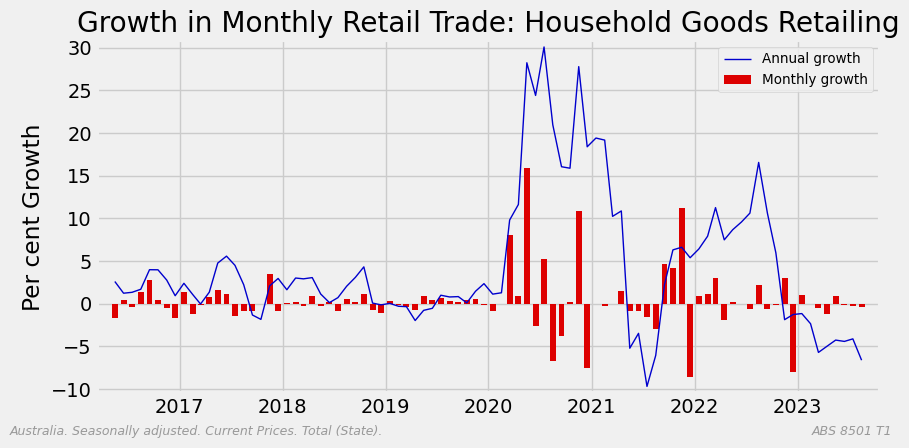

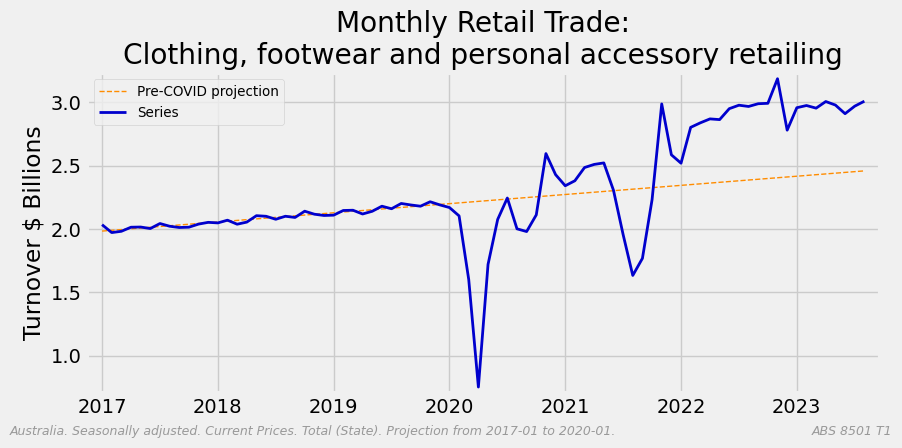

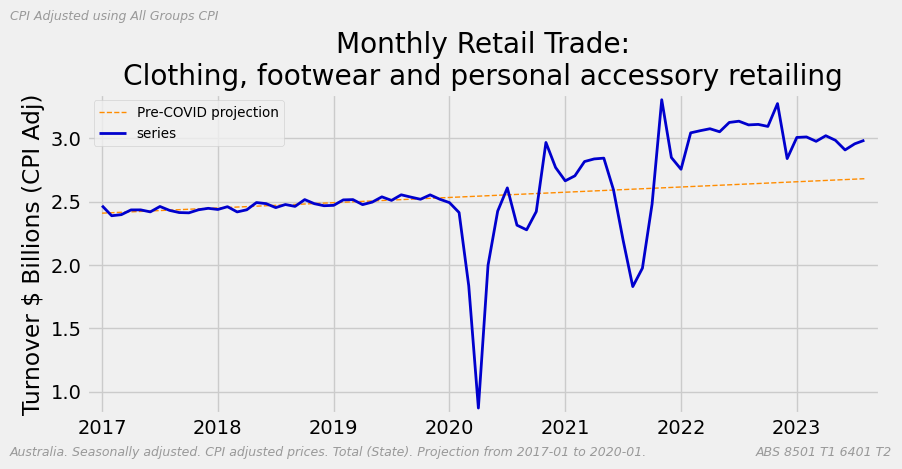

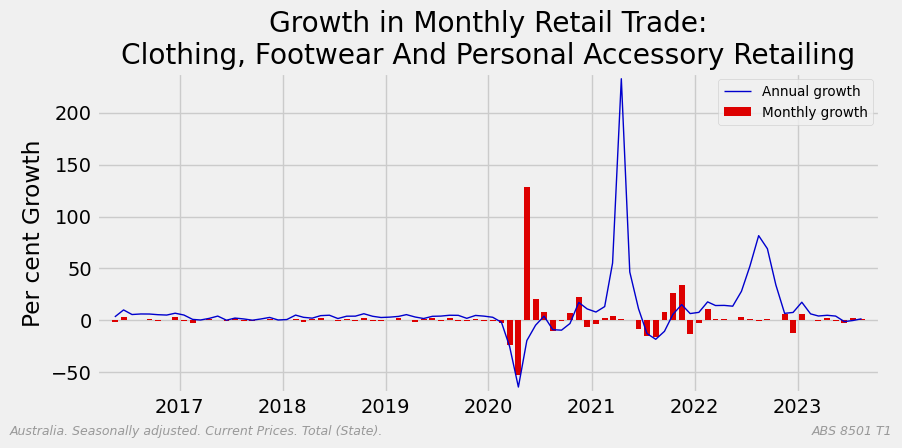

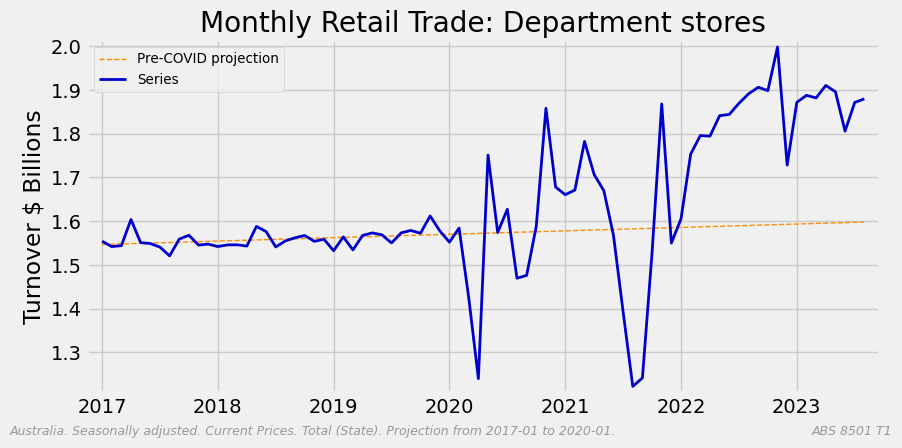

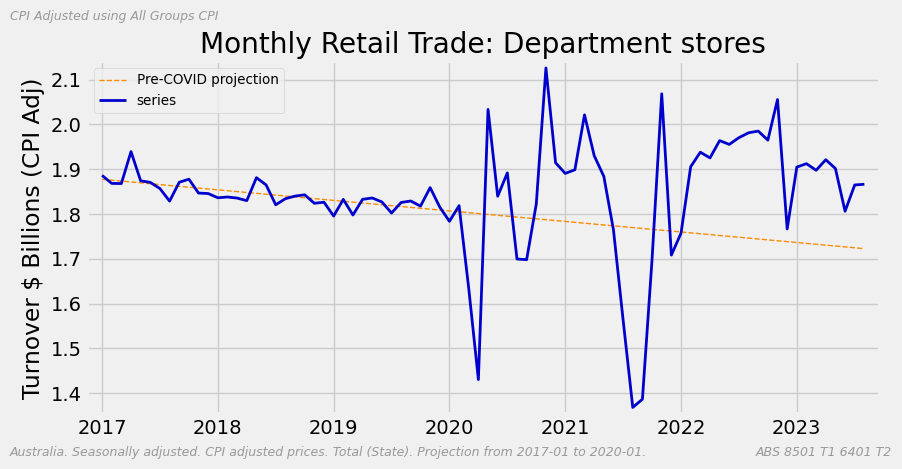

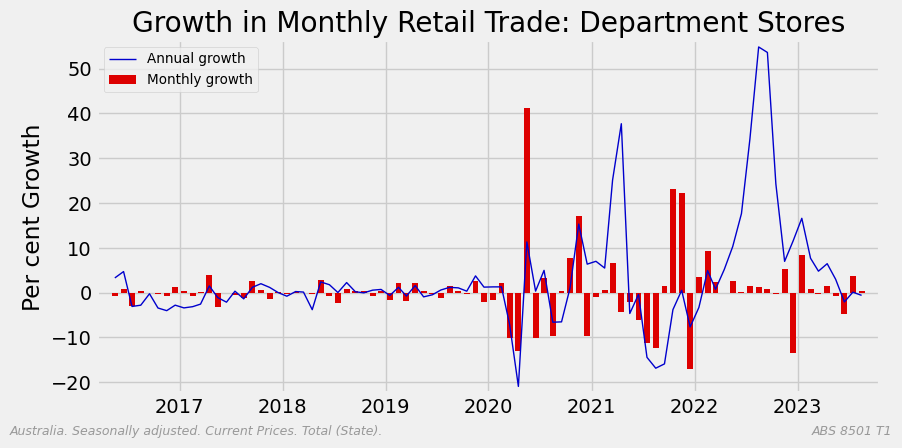

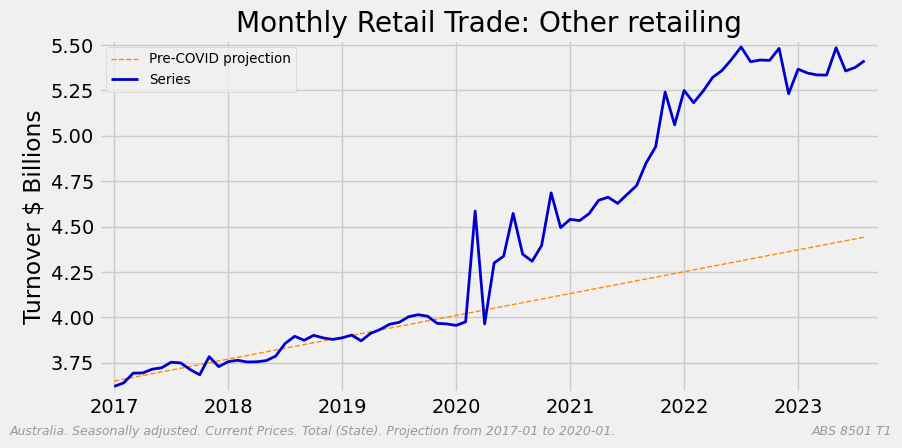

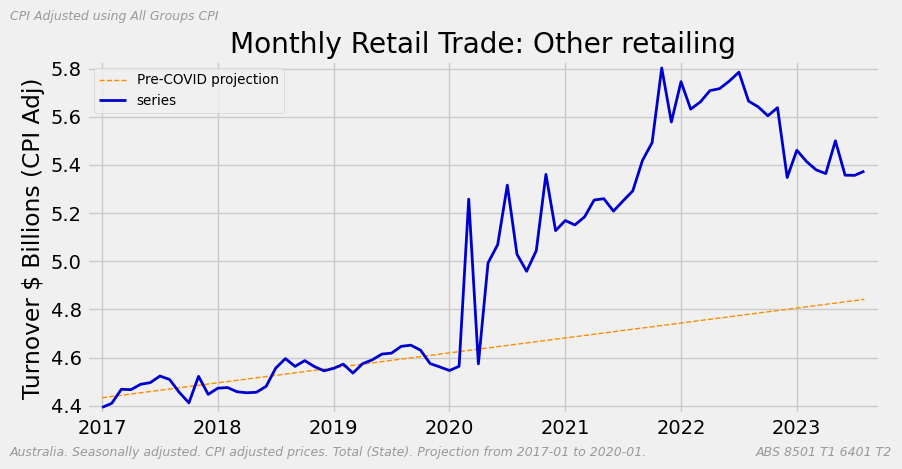

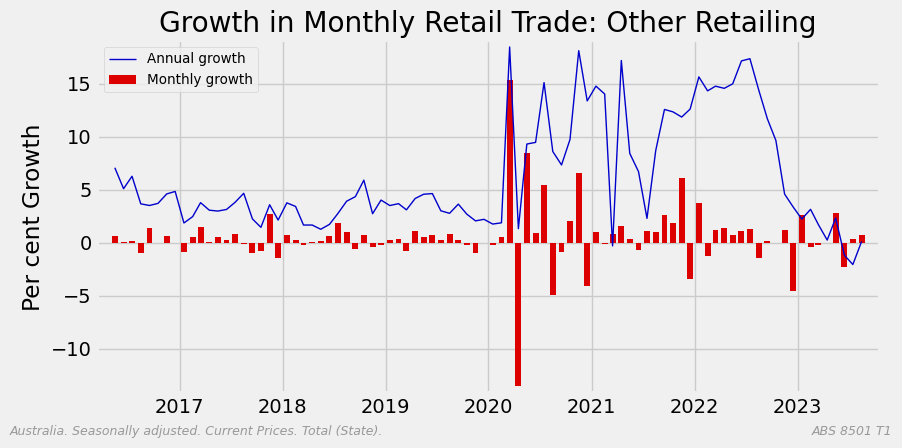

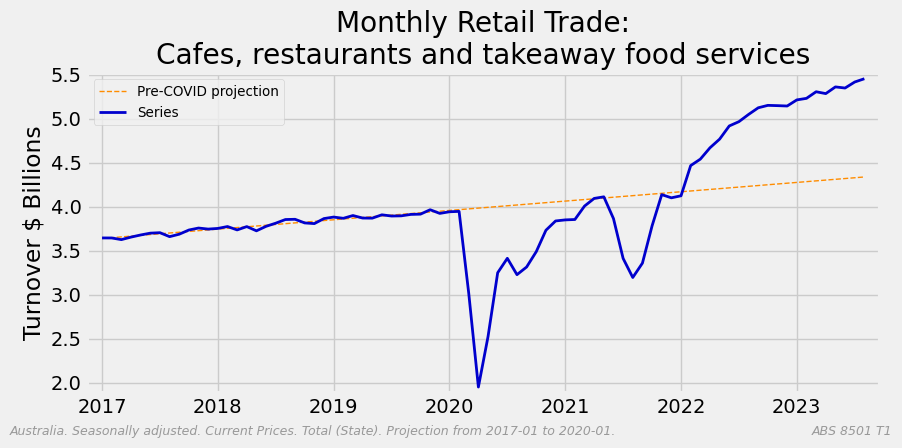

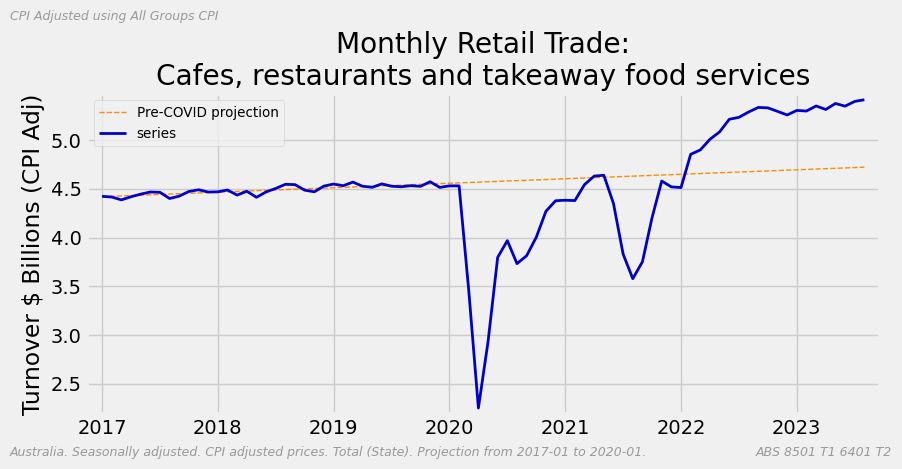

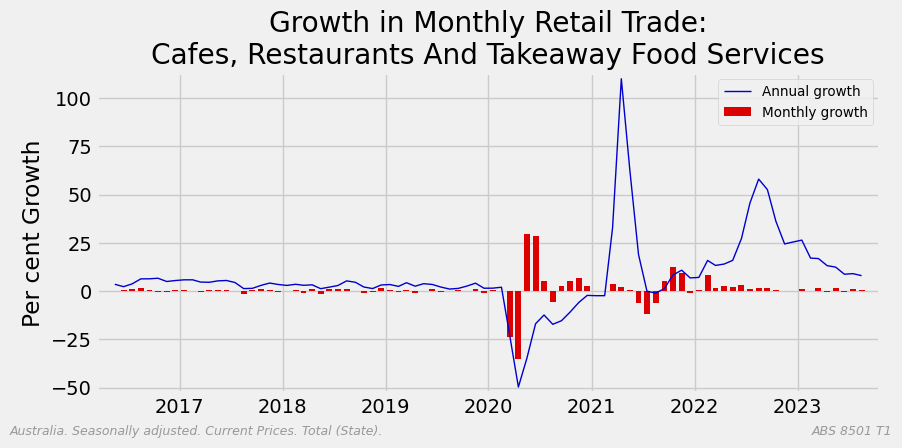

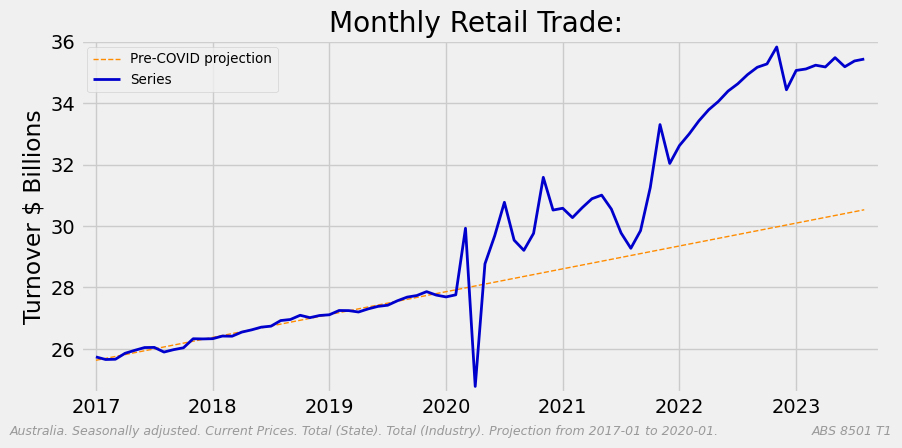

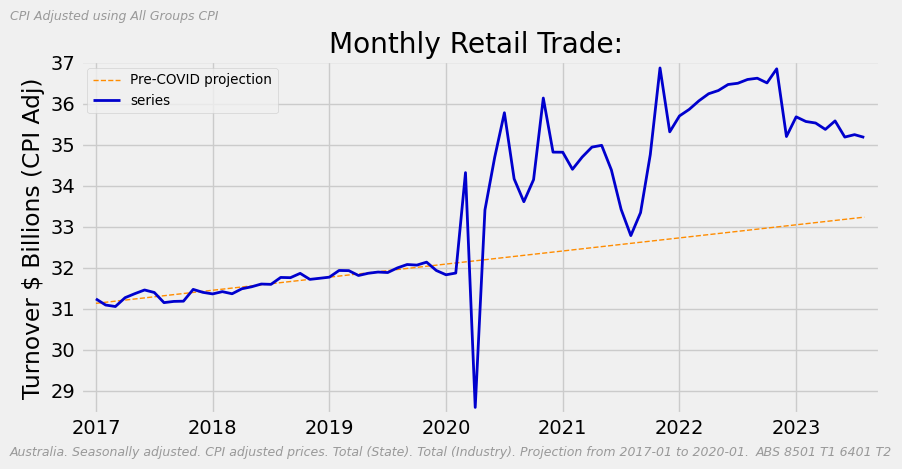

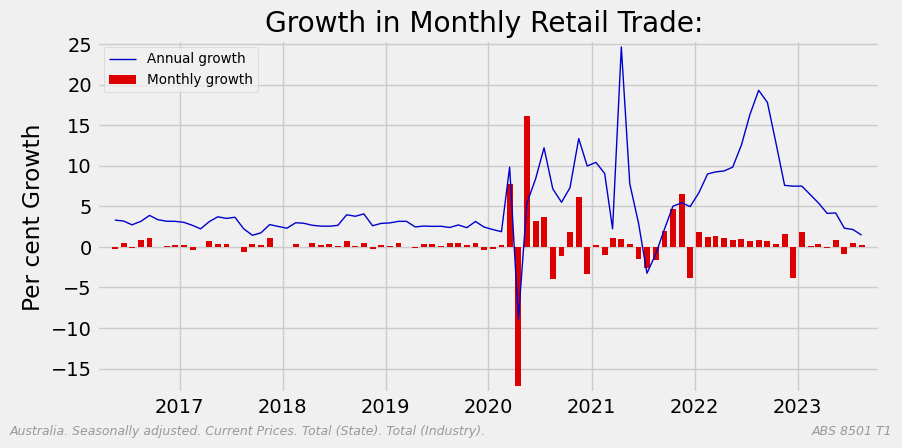

In [9]:
series_type = "Seasonally Adjusted"
rows = retail_meta[
    retail_meta[did_col].str.contains("Turnover", regex="False")
    & retail_meta[unit_col].str.contains("$", regex="False")
    & (retail_meta[type_col] == series_type)
]

recent = plot_times[1]
for index, row in rows.iterrows():
    # get the data for wacg plotable item
    series_id, units, table = row[id_col], row[unit_col], row[table_col]
    data = retail_dict[table]
    series, units = recalibrate_series(data[series_id], units)
    series_freq = series.index.freqstr
    check = pd.Period("2017-01-01", freq=series_freq)
    check_series = series[series.index > check]
    if len(check_series) != len(check_series.dropna()):
        print(f"Odd or missing data: {row[did_col]}")
        continue

    # plot the data
    HEADLINE = "!"
    pre_tag = HEADLINE if table in ["1", "7"] else ""
    series.name = "Series"
    MONTHLY = "Monthly"
    frequency = {"Q": "Quarterly", "M": MONTHLY}[series_freq[0]]
    lfooter = f"Australia. {series_type.capitalize()}. "
    current_prices = "Current Prices. "
    lfooter += "Current Prices. " if frequency == MONTHLY else ""
    title, lfooter = fix_abs_title(row[did_col], lfooter)
    separator = "\n" if len(title) > LONG_LABEL else " "
    title = (
        f"{frequency} Retail Trade:{separator}"
        # Move "Turnover" to the y-axis label.
        f"{title.replace('Turnover', '').strip()}"
    )
    plot_covid_recovery(
        series,
        title=title,
        ylabel=f"Turnover {units}",
        pre_tag=pre_tag,
        rfooter=f"{source} T{table}",
        lfooter=lfooter,
        show=pre_tag == HEADLINE and SHOW,
    )

    if pre_tag == HEADLINE and frequency == MONTHLY:
        cpi_adj_series = (series / cpi_m).dropna()
        cpi_adj_series.name = "series"
        plot_covid_recovery(
            cpi_adj_series,
            title=title,
            ylabel=f"Turnover {units} (CPI Adj)",
            pre_tag=pre_tag,
            tags="cpi-adjusted",
            rfooter=f"{source} T{table} {cpi_catalogue_id} T{cpi_table}",
            lfooter=lfooter.replace(current_prices, "CPI adjusted prices. "),
            lheader="CPI Adjusted using All Groups CPI",
            show=pre_tag == HEADLINE and SHOW,
        )

    if pre_tag == HEADLINE:
        # Only do growth charts on headline items
        growth = calc_growth(series)
        plot_growth_finalise(
            *growth,
            from_=pd.Period(recent, freq=series.index.freqstr[0]),
            title=f"Growth in {title.title()}",
            pre_tag=HEADLINE,
            rfooter=f"{source} T{table}",
            lfooter=lfooter,
            show=SHOW,
        )

## Finished

In [10]:
# watermark
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Fri Sep 29 2023 09:41:49

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

pandas    : 2.1.1
sys       : 3.11.5 | packaged by conda-forge | (main, Aug 27 2023, 03:35:23) [Clang 15.0.7 ]
matplotlib: 3.8.0

Watermark: 2.4.3



In [11]:
print("Finished")

Finished
